# Bike sharing demand forecast (on daily data)

Predict bike sharing demand as a function of seasonal and weather conditions.

Data origin:
- original full dataset (by hour, not used here): https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
- simplified dataset (by day, with some simple scaling): https://www.hds.utc.fr/~tdenoeux/dokuwiki/en/aec
    - description: https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/exam_2019_ace_.pdf
    - data: https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/bike_sharing_day.csv.zip
    
Note that even if we are estimating a time serie, we are not using here a recurrent neural network as we assume the temporal dependence to be negligible (i.e. Y_t = f(X_t) alone).

In [21]:
###########################################################################################
### With scaling of the X, correction of measure unit for Y & dummification (but no PCA)...
###########################################################################################
using Pkg
function addIfNeeded(pkgs...)
    isinstalled(pkg::String) = any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
    [Pkg.add(pkg) for pkg in pkgs  if !isinstalled(pkg)]
end

addIfNeeded("DataFrames","CSV","StatsPlots","Distributions")

using LinearAlgebra, Random, DataFrames, CSV, StatsPlots, BetaML.Nn
import Distributions: Uniform

import Random:seed!
seed!(123)

MersenneTwister(UInt32[0x0000007b], Random.DSFMT.DSFMT_state(Int32[1464307935, 1073116007, 222134151, 1073120226, -290652630, 1072956456, -580276323, 1073476387, 1332671753, 1073438661  …  138346874, 1073030449, 1049893279, 1073166535, -1999907543, 1597138926, -775229811, 32947490, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x0000000000000

In [22]:
# Data loading and cleaning..
baseDir = "assets/bikeSharingDemandForecast/"
data = DataFrame!(CSV.File(joinpath(baseDir,"bike_sharing_day.csv"),delim=',',copycols=true))
describe(data)

MethodError: MethodError: no method matching CSV.File(::CSV.Header{false,Parsers.Options{false,false,true,false,Missing,UInt8,Nothing},Array{UInt8,1}}; debug=false, typemap=Dict{Type,Type}(), copycols=true)
Closest candidates are:
  CSV.File(::CSV.Header; startingbyteposition, endingbyteposition, limit, threaded, typemap, tasks, debug) at /home/lobianco/.julia/packages/CSV/W9RT2/src/file.jl:229 got unsupported keyword argument "copycols"
  CSV.File(::Any; header, normalizenames, datarow, skipto, footerskip, transpose, comment, use_mmap, ignoreemptylines, select, drop, missingstrings, missingstring, delim, ignorerepeated, quotechar, openquotechar, closequotechar, escapechar, dateformat, dateformats, decimal, truestrings, falsestrings, type, types, typemap, categorical, pool, lazystrings, strict, silencewarnings, debug, parsingdebug, kw...) at /home/lobianco/.julia/packages/CSV/W9RT2/src/file.jl:216

In [3]:
seasonDummies = convert(Array{Float64,2},oneHotEncoder(data[:,:season]))
weatherDummies = convert(Array{Float64,2},oneHotEncoder(data[:,:weathersit]))
wdayDummies = convert(Array{Float64,2},oneHotEncoder(data[:,:weekday] .+ 1 ))

x    = hcat(convert(Array{Float64,2},data[:,[:instant,:yr,:mnth,:holiday,:workingday,:temp,:atemp,:hum,:windspeed]]),
            seasonDummies,
            weatherDummies,
            wdayDummies)
y    = data[:,16] 
colsNotToScale = [2;4;5;10:23]

# Split the data in training/testing sets
ntrain    = Int64(round(size(x,1)*0.75))
nval      = Int64(round(size(x,1)*0.125))
ntest     = size(x,1) - (ntrain+nval)
xtrain    = x[1:ntrain,:]
ytrain    = y[1:ntrain]
xval      = x[(ntrain+1):(ntrain+nval),:]
yval      = y[(ntrain+1):(ntrain+nval)]
xtest     = x[ntrain+nval+1:end,:]
ytest     = y[ntrain+nval+1:end]

xScaleFactors = getScaleFactors(xtrain,skip=colsNotToScale)
yScaleFactors = ([0],[0.001]) # getScaleFactors(ytrain) # This just divide by 1000. Using full scaling of Y we may get negative demand.

xtrainScaled = scale(xtrain,xScaleFactors)

xvalScaled   = scale(xval,xScaleFactors)
xtestScaled  = scale(xtest,xScaleFactors)
ytrainScaled = scale(ytrain,yScaleFactors)
out    = pca(xtrainScaled,error=0.05)
xtrainScaledPca = xtrainScaled #out.X  # change these lines if you want to run PCA (doesn't seem to improve)
xvalScaledPca   = xvalScaled   #xvalScaled*out.P
xtestScaledPca  = xtestScaled  #xtestScaled*out.P
D = size(xtrainScaledPca,2)

23

In [4]:
# Train using validation set to select the hyperpharameters (may take a while)
epochsToTest = [10,20,40,80,160,320,640,1200]
hiddenLayerSizes = [5,8,12,15,20,25,30]
bestEpoch = 0
bestSize = 0
bestValError = Inf
errorsMatrix = fill(Inf64,length(epochsToTest),length(hiddenLayerSizes))

for (ne,epoch) in enumerate(epochsToTest), (nls,ls) in enumerate(hiddenLayerSizes)

    global bestValError, bestSize, errorsMatrix, bestEpoch
    println("Testing epochs $epoch, layer size $ls ...")
    # Note that the Xavier initialisation is now by default, so you don't need to specify w and wb to get it...
    l1   = DenseLayer(D,ls,f=sigmoid, w=rand(Uniform(-sqrt(6)/sqrt(D+ls),sqrt(6)/sqrt(D+ls)),ls,D), wb=rand(Uniform(-sqrt(6)/sqrt(D+ls),sqrt(6)/sqrt(D+ls)),ls)   ) # Activation function is ReLU
    l2   = DenseLayer(ls,1,f=relu, w=rand(Uniform(-sqrt(6)/sqrt(1+15),sqrt(6)/sqrt(1+15)),1,ls), wb=rand(Uniform(-sqrt(6)/sqrt(ls+1),sqrt(6)/sqrt(ls+1)),1) )
    mynn = buildNetwork([l1,l2],squaredCost,name="Bike sharing regression model") # Build the NN and use the squared cost (aka MSE) as error function

    # Training it (default to ADAM)
    res  = train!(mynn,xtrainScaledPca,ytrainScaled,epochs=epoch,batchSize=8,optAlg=ADAM(),verbosity=NONE) # Use optAlg=SGD() to use Stochastic Gradient Descent
    ŷval = scale(predict(mynn,xvalScaledPca),yScaleFactors,rev=true)
    
    meanRelErrorVal   = meanRelError(ŷval,yval)
    if meanRelErrorVal < bestValError
        bestValError = meanRelErrorVal
        bestSize = ls
        bestEpoch = epoch
    end
    errorsMatrix[ne,nls] = meanRelErrorVal
end

errorsMatrix

Testing epochs 10, layer size 5 ...
Testing epochs 10, layer size 8 ...
Testing epochs 10, layer size 12 ...
Testing epochs 10, layer size 15 ...
Testing epochs 10, layer size 20 ...
Testing epochs 10, layer size 25 ...
Testing epochs 10, layer size 30 ...
Testing epochs 20, layer size 5 ...
Testing epochs 20, layer size 8 ...
Testing epochs 20, layer size 12 ...
Testing epochs 20, layer size 15 ...
Testing epochs 20, layer size 20 ...
Testing epochs 20, layer size 25 ...
Testing epochs 20, layer size 30 ...
Testing epochs 40, layer size 5 ...
Testing epochs 40, layer size 8 ...
Testing epochs 40, layer size 12 ...
Testing epochs 40, layer size 15 ...
Testing epochs 40, layer size 20 ...
Testing epochs 40, layer size 25 ...
Testing epochs 40, layer size 30 ...
Testing epochs 80, layer size 5 ...
Testing epochs 80, layer size 8 ...
Testing epochs 80, layer size 12 ...
Testing epochs 80, layer size 15 ...
Testing epochs 80, layer size 20 ...
Testing epochs 80, layer size 25 ...
Testing e

8×7 Array{Float64,2}:
 0.570216  0.388596  1.0       1.0       0.160844  0.153205  0.133044
 0.280847  0.203433  0.199212  0.153144  0.142216  0.141346  0.132062
 0.176492  0.152391  1.0       0.126039  0.134417  0.131962  0.129711
 0.123529  0.125179  0.119359  0.116717  0.119867  0.113942  1.0
 0.126717  0.112116  0.110524  0.126036  0.111267  1.0       0.13422
 0.145019  0.108921  0.10633   0.140739  0.11766   0.131421  1.0
 0.160986  0.137969  1.0       0.158326  0.142622  0.166896  0.163361
 0.187275  0.119644  0.118003  0.138624  0.165737  0.134539  0.117754

In [5]:
# Re-doing training with the best hyperparameters:
ls    = bestSize
epoch = bestEpoch

println("Final training of $epoch epochs, with layer size $ls ...")
# Note that the Xavier initialisation is now by default, so you don't need to specify w and wb to get it...
l1   = DenseLayer(D,ls,f=sigmoid, w=rand(Uniform(-sqrt(6)/sqrt(D+ls),sqrt(6)/sqrt(D+ls)),ls,D), wb=rand(Uniform(-sqrt(6)/sqrt(D+ls),sqrt(6)/sqrt(D+ls)),ls)   ) # Activation function is ReLU
l2   = DenseLayer(ls,1,f=identity, w=rand(Uniform(-sqrt(6)/sqrt(1+15),sqrt(6)/sqrt(1+15)),1,ls), wb=rand(Uniform(-sqrt(6)/sqrt(ls+1),sqrt(6)/sqrt(ls+1)),1) )
mynn = buildNetwork([l1,l2],squaredCost,name="Bike sharing regression model") # Build the NN and use the squared cost (aka MSE) as error function

# Training it (default to ADAM)
res  = train!(mynn,xtrainScaledPca,ytrainScaled,epochs=epoch,batchSize=8,optAlg=ADAM()) # Use optAlg=SGD() to use Stochastic Gradient Descent

Final training of 320 epochs, with layer size 12 ...
***
*** Training Bike sharing regression model for 320 epochs with algorithm ADAM.
Training.. 	 avg ϵ on (Epoch 1 Batch 68): 	 3.614306148395766
Training.. 	 avg ϵ on (Epoch 32 Batch 68): 	 0.08508164201806434


Training the Neural Network... 11%|██▍                  |  ETA: 0:00:08

Training.. 	 avg ϵ on (Epoch 64 Batch 68): 	 0.1484287641736481


Training the Neural Network... 26%|█████▍               |  ETA: 0:00:07

Training.. 	 avg ϵ on (Epoch 96 Batch 68): 	 0.120140721037722


Training the Neural Network... 38%|████████▏            |  ETA: 0:00:05

Training.. 	 avg ϵ on (Epoch 128 Batch 68): 	 0.03592035940884935
Training.. 	 avg ϵ on (Epoch 160 Batch 68): 	 0.06209143611696868


Training the Neural Network... 51%|██████████▋          |  ETA: 0:00:04

Training.. 	 avg ϵ on (Epoch 192 Batch 68): 	 0.15202971996440465


Training the Neural Network... 63%|█████████████▎       |  ETA: 0:00:03

Training.. 	 avg ϵ on (Epoch 224 Batch 68): 	 0.1118654540436257


Training the Neural Network... 75%|███████████████▉     |  ETA: 0:00:02

Training.. 	 avg ϵ on (Epoch 256 Batch 68): 	 0.18080495509307565


Training the Neural Network... 88%|██████████████████▌  |  ETA: 0:00:01

Training.. 	 avg ϵ on (Epoch 288 Batch 68): 	 0.13052984131646153


Training the Neural Network...100%|█████████████████████| Time: 0:00:08


Training.. 	 avg ϵ on (Epoch 320 Batch 68): 	 0.037283127857696094
Training of 320 epoch completed. Final epoch error: 0.08047688330218579.


(epochs = 320, ϵ_epochs = [9.182473834692267, 6.400316152298417, 4.483615178189874, 3.16614591542958, 2.2733372889848025, 1.683089710253344, 1.2961487587528842, 1.0405699452602197, 0.8580738770332355, 0.7259129824524282  …  0.08149581479167124, 0.08140522430130558, 0.08131144910655276, 0.08113630039661195, 0.08103760974414624, 0.08096841592439752, 0.08091533083955975, 0.08068864639049267, 0.08059882119186444, 0.08047688330218579], θ_epochs = Any[])

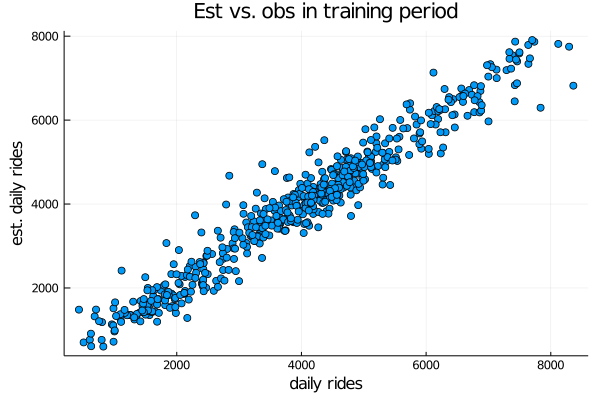

In [6]:
ŷtrain  = max.(0.0,scale(predict(mynn,xtrainScaledPca),yScaleFactors,rev=true))
scatter(ytrain,ŷtrain,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in training period")

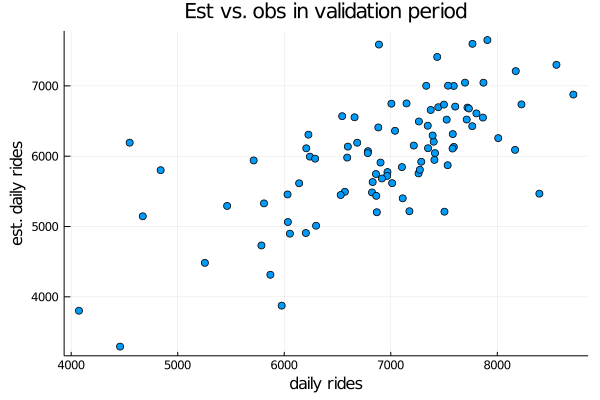

In [7]:
ŷval = max.(0.0,scale(predict(mynn,xvalScaledPca),yScaleFactors,rev=true))
scatter(yval,ŷval,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in validation period")

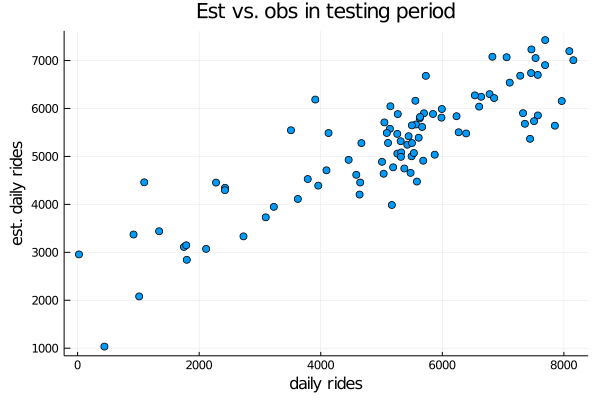

In [8]:
ŷtest  = max.(0.0,scale(predict(mynn,xtestScaledPca),yScaleFactors,rev=true))
scatter(ytest,ŷtest,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in testing period")

In [9]:
mean(abs.(ŷtest .- ytest))/mean(ytest)

UndefVarError: UndefVarError: mean not defined

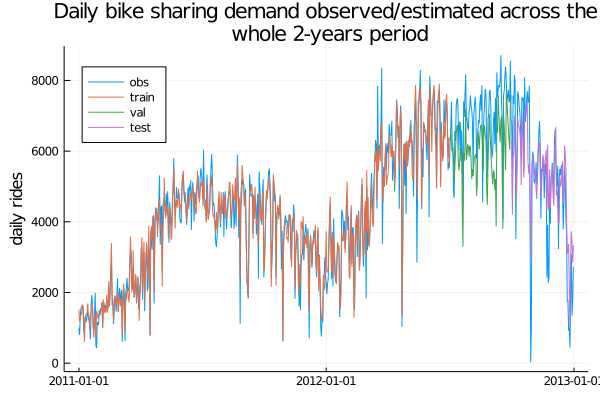

In [10]:
# Full period plot (2 years)
ŷtrainfull = vcat(ŷtrain,fill(missing,nval+ntest))
ŷvalfull = vcat(fill(missing,ntrain), ŷval, fill(missing,ntest))
ŷtestfull = vcat(fill(missing,ntrain+nval), ŷtest)
plot(data[:,:dteday],[data[:,:cnt] ŷtrainfull ŷvalfull ŷtestfull], label=["obs" "train" "val" "test"], legend=:topleft, ylabel="daily rides", title="Daily bike sharing demand observed/estimated across the\n whole 2-years period")

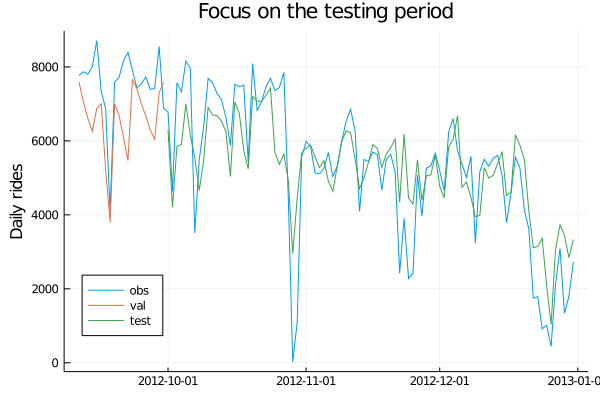

In [11]:
# Focus on testing data
stc = 620
endc = size(x,1)
plot(data[stc:endc,:dteday],[data[stc:endc,:cnt] ŷvalfull[stc:endc] ŷtestfull[stc:endc]], label=["obs" "val" "test"], legend=:bottomleft, ylabel="Daily rides", title="Focus on the testing period")

## Comparation with Flux

Disclaimer: I'm a nebbie with [Flux](https://fluxml.ai/), this is likelly not to be the best approach

In [12]:
using Flux

In [13]:
# Defining the net model and load it with data...
Flux_nn = Chain(Dense(D,ls,Flux.sigmoid),
                Dense(ls,1,identity))

loss(x, y) = Flux.mse(Flux_nn(x), y)
ps = Flux.params(Flux_nn)
nndata = Flux.Data.DataLoader(xtrainScaledPca', ytrainScaled', batchsize=8,shuffle=true) 

Flux.Data.DataLoader(([-1.728893009486523 -1.722571645649278 … 1.722571645649278 1.728893009486523; 0.0 0.0 … 1.0 1.0; … ; 0.0 0.0 … 0.0 0.0; 1.0 0.0 … 1.0 0.0], [0.985 0.801 … 5.687 5.531]), 8, 548, true, 548, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  539, 540, 541, 542, 543, 544, 545, 546, 547, 548], true)

In [14]:
# Training of the Flux model...
Flux.@epochs epoch Flux.train!(loss, ps, nndata, Flux.ADAM(0.001, (0.9, 0.8)))

┌ Info: Epoch 1
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 2
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 3
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 4
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 5
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 6
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 7
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 8
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 9
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 10
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 11
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/s

┌ Info: Epoch 89
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 90
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 91
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 92
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 93
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 94
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 95
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 96
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 97
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 98
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 99
└ @ Main /home/lobianco/.julia/packages/Flu

┌ Info: Epoch 181
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 182
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 183
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 184
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 185
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 186
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 187
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 188
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 189
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 190
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 191
└ @ Main /home/lobianco/.julia/p

┌ Info: Epoch 275
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 276
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 277
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 278
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 279
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 280
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 281
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 282
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 283
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 284
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 285
└ @ Main /home/lobianco/.julia/p

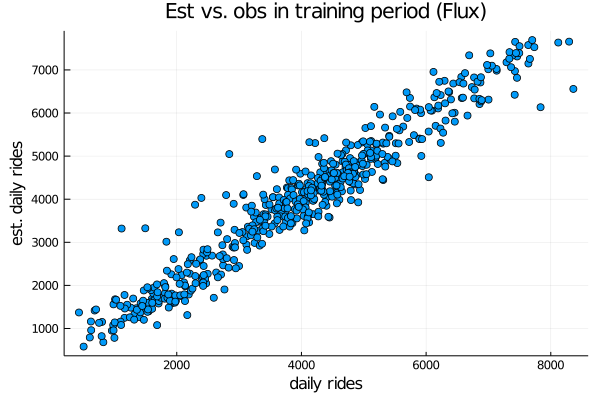

In [15]:
ŷtrainf = max.(0.0,scale(Flux_nn(xtrainScaledPca')',yScaleFactors,rev=true))
scatter(ytrain,ŷtrainf,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in training period (Flux)")

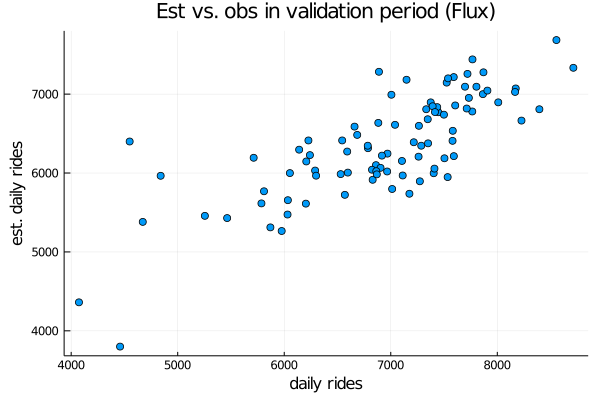

In [16]:
ŷvalf = max.(0.0,scale(Flux_nn(xvalScaledPca')',yScaleFactors,rev=true))
scatter(yval,ŷvalf,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in validation period (Flux)")

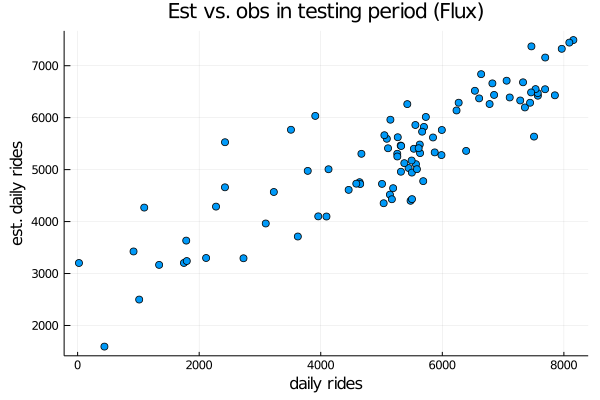

In [17]:
ŷtestf  = max.(0.0,scale(Flux_nn(xtestScaledPca')',yScaleFactors,rev=true))
scatter(ytest,ŷtestf,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in testing period (Flux)")

In [18]:
mean(abs.(ŷtestf .- ytest))/mean(ytest)

UndefVarError: UndefVarError: mean not defined

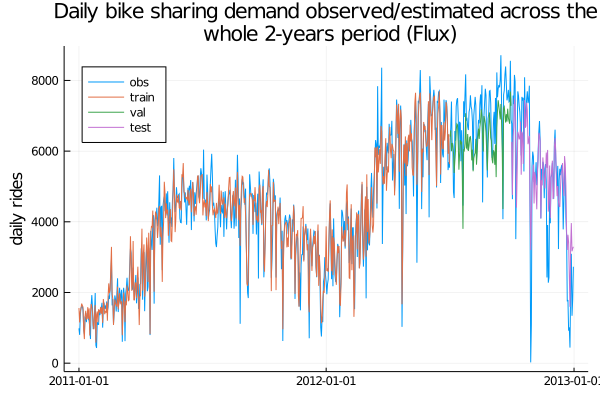

In [19]:
# Full period plot (2 years)
ŷtrainfullf = vcat(ŷtrainf,fill(missing,nval+ntest))
ŷvalfullf = vcat(fill(missing,ntrain), ŷvalf, fill(missing,ntest))
ŷtestfullf = vcat(fill(missing,ntrain+nval), ŷtestf)
plot(data[:,:dteday],[data[:,:cnt] ŷtrainfullf ŷvalfullf ŷtestfullf], label=["obs" "train" "val" "test"], legend=:topleft, ylabel="daily rides", title="Daily bike sharing demand observed/estimated across the\n whole 2-years period (Flux)")

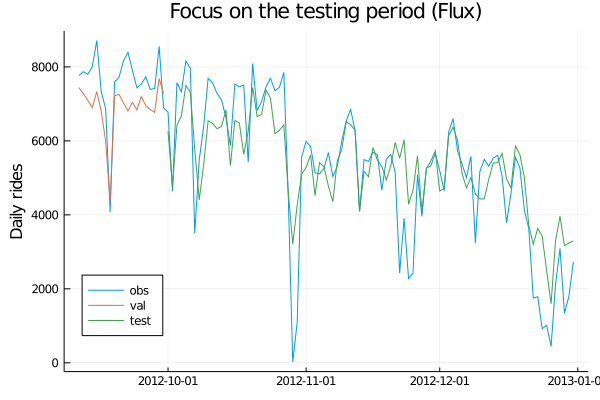

In [20]:
# Focus on testing data
stc = 620
endc = size(x,1)
plot(data[stc:endc,:dteday],[data[stc:endc,:cnt] ŷvalfullf[stc:endc] ŷtestfullf[stc:endc]], label=["obs" "val" "test"], legend=:bottomleft, ylabel="Daily rides", title="Focus on the testing period (Flux)")